## Import libraries

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import geopandas as gpd

### Internet Usage

In [2]:
df_real = pd.read_csv('data/internet_usage.csv')
df_real.drop(['ITTER107', 'TIPO_DATO_AVQ', 'MISURA_AVQ', 'MISURA_AVQ', 'Seleziona periodo', 'Flag Codes', 'Flags', "Misura"], axis=1, inplace=True)

df_real = df_real.loc[~(df_real['Territory'] == "Provincia Autonoma Trento"),:]
df_real = df_real.loc[~(df_real['Territory'] == "Provincia Autonoma Bolzano / Bozen"),:]

df_real.head()

,Territory,Data type,TIME,Value
0,Toscana,una o più volte alla settimana,2018,13.5
1,Toscana,una o più volte alla settimana,2019,14.8
2,Liguria,una o più volte alla settimana,2018,13.1
3,Liguria,una o più volte alla settimana,2019,14.3
4,Piemonte,qualche volta al mese,2018,2.0


In [3]:
category_1 = 'usano Internet'

### Base case

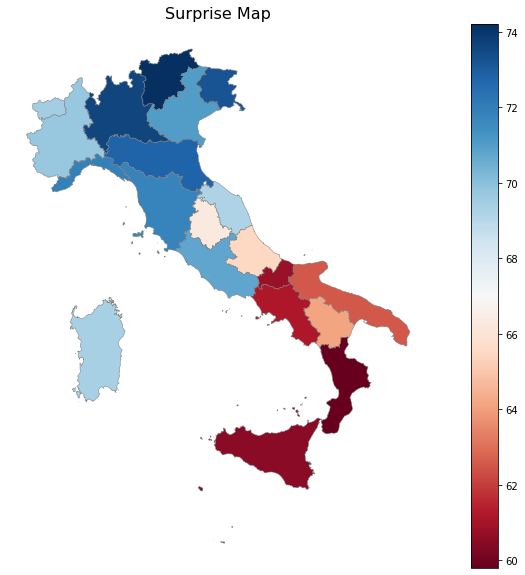

In [4]:
df = df_real.copy()

map_reg = gpd.read_file(os.path.join('..', 'assets', 'maps', 'Reg01012019_g', 'Reg01012019_g_WGS84.shp'))
map_reg['DEN_REG'] = map_reg['DEN_REG'].replace({'Friuli Venezia Giulia': 'Friuli-Venezia Giulia', 'Trentino-Alto Adige': 'Trentino Alto Adige / Südtirol', "Valle d'Aosta": "Valle d'Aosta / Vallée d'Aoste"})
# Merge the map with the pandas df
filtered_df_1 = df.loc[(df['TIME'] == 2018) & (df['Data type'] == category_1),:]

merged = pd.merge(map_reg, filtered_df_1, left_on='DEN_REG', right_on='Territory', how='left')

fig, ax = plt.subplots(1, figsize=(15, 10))
ax.axis('off')
ax.set_title('Surprise Map', fontsize=16)
cmap = plt.get_cmap('RdBu')
merged.plot(column='Value', vmin = min(merged['Value']), vmax=max(merged['Value']), cmap=cmap, linewidth=0.5, ax=ax, edgecolor='0.5', legend=True)

## Internet usage vs Age

### Load Mean age

In [5]:
age = pd.read_csv('data/mean_age.csv')
age.drop(['ITTER107', 'TIPO_DATO15', 'Select time', 'Flag Codes', 'Flags', "Indicator"], axis=1, inplace=True)

df = df_real.copy()
age.head()

,Territory,TIME,Value
0,Piemonte,2015,46.2
1,Piemonte,2016,46.4
2,Piemonte,2017,46.6
3,Piemonte,2018,46.8
4,Piemonte,2019,47.0


## Compute the surprise

In [6]:
surprise_data = []
for index, region in enumerate(df['Territory'].unique()):
    surprise_data.append([])
    for _ in range(len(df['TIME'].unique())): # 2
        surprise_data[index].append(0)

In [7]:
# Since we have only one model...
pM = 1

# FOR NOW LET'S FOCUS ONLY ON THE 'OBTAINING INFORMATION' INTERACTION

for k, year in enumerate(df['TIME'].unique()):
    # Compute the average rate of the current year
    avg_rate = np.mean(df.loc[(df['TIME'] == year) & (df['Data type'] == category_1)]['Value'])
    # Compute the sum of the rates of the current year
    sum_rate = np.sum(df.loc[(df['TIME'] == year) & (df['Data type'] == category_1)]['Value'])
    
    # Get the list of regions ordered by age of the current year
    current_age = age.loc[age['TIME'] == year].sort_values(by=['Value'], ascending=False)
    
    for j, region in enumerate(df['Territory'].unique()):
        # Estimate P(D|M) as 1 - |O - E|
        O = (df.loc[(df['TIME'] == 2019) & (df['Territory'] == region) & (df['Data type'] == category_1)]['Value'] / sum_rate).item()
        # Get the region with the highest age in the current year
        highest_age = age.loc[age['TIME'] == year].max()['Territory']
        # Get the index of the current region in the ordered age list
        index = list(current_age['Territory']).index(region)
        # Get the current data observed and sort them
        obs_data = df.loc[(df['TIME'] == year) & (df['Data type'] == category_1)]
        obs_data.sort_values(by=['Value'], ascending=False, inplace=True)
        # Get the expected value
        E = (obs_data.iloc[index]['Value'] / sum_rate).item()
        
        # P(D|M)
        pDM = 1 - np.abs(O - E)
        
        # Estimate P(M|D)
        pMD = pDM * pM
        
        # Surprise is the sum of KL divergance across model space (only one here)
        kl = pMD * (np.log(pMD / pM) / np.log(2))
        surprise_data[j][k] = np.abs(kl) if (O - E) > 0 else -np.abs(kl)
        
    # Now let's globally update our model belief
    pDM = 1 - (0.5 * np.abs(O - E))
    pMD = pDM * pM
    pM = pMD

C:\Users\Roncax\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Plot the result

In [8]:
# Starting from the surprise data, create a dataframe
df_structure = {}
for region in df['Territory'].unique():
    df_structure[region] = []
for index, region in enumerate(df_structure):
    df_structure[region] = surprise_data[index]

surprise_df = pd.DataFrame(df_structure).transpose()
surprise_df.index.name = 'Territory'
surprise_df.columns = [str(year) for year in df['TIME'].unique()]

In [9]:
surprise_df.head()

,2018,2019
Territory,,
Toscana,0.000956,-0.000000
Liguria,-0.004244,-0.005373
Piemonte,-0.002123,-0.003515
Friuli-Venezia Giulia,0.001062,-0.000621
Marche,-0.000850,-0.001242


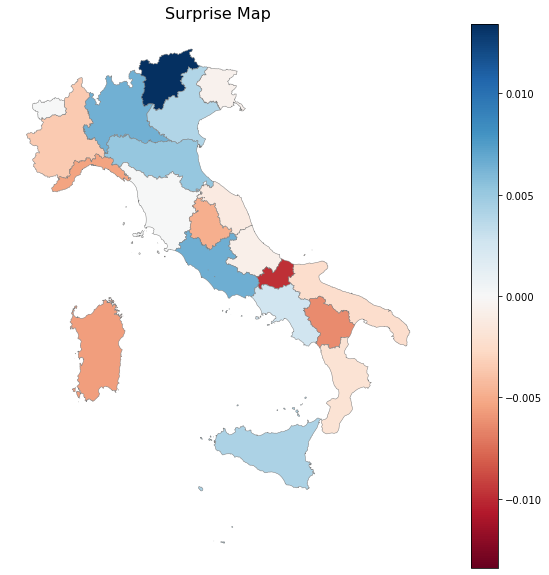

In [10]:
map_reg = gpd.read_file(os.path.join('..', 'assets', 'maps', 'Reg01012019_g', 'Reg01012019_g_WGS84.shp'))
map_reg['DEN_REG'] = map_reg['DEN_REG'].replace({'Friuli Venezia Giulia': 'Friuli-Venezia Giulia', 'Trentino-Alto Adige': 'Trentino Alto Adige / Südtirol', "Valle d'Aosta": "Valle d'Aosta / Vallée d'Aoste"})
# Merge the map with the pandas df
merged = pd.merge(map_reg, surprise_df, left_on='DEN_REG', right_on='Territory', how='left')

YEAR = '2019'
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.axis('off')
ax.set_title('Surprise Map', fontsize=16)
cmap = plt.get_cmap('RdBu')
max_abs_value = max(np.abs(min(merged[YEAR])), np.abs(max(merged[YEAR])))
merged.plot(column=YEAR, vmin = -max_abs_value, vmax = max_abs_value, cmap=cmap, linewidth=0.5, ax=ax, edgecolor='0.5', legend=True)

## Internet usage vs graduates

### Load graduates

In [11]:
graduates = pd.read_csv('data/graduates.csv')
graduates.drop(['ITTER107', 'TIPO_DATO6', 'Select time', 'Flag Codes', 'Flags', 'Type of data', 'AREADIDATTICA', 'Type of university', 'NATGIUR', 'TIPCORSOLAUREA', 'SEXISTAT1' ], axis=1, inplace=True)

graduates = graduates.loc[(graduates['Type of programme'] == "total"),:]
graduates = graduates.loc[(graduates['Field of study'] == "total"),:]
graduates = graduates.loc[(graduates['Gender'] == "total"),:]
graduates = graduates.rename(columns={'Region of study': 'Territory'})

graduates = graduates.loc[~(graduates['Territory'] == "Provincia Autonoma Trento"),:]
graduates = graduates.loc[~(graduates['Territory'] == "Provincia Autonoma Bolzano / Bozen"),:]

# We need the population of each region (only individuals aged 14 and over, since our event rates are referred to them)
# Year = 2012 - 2018
population_df = pd.read_csv('data/regions_population.csv')
population_df.drop(['ITTER107', 'TIPO_DATO15', 'Demographic data type', 'SEXISTAT1', 'Gender', 'ETA1', 'STATCIV2', 'Marital status', 'Select time', 'Flag Codes', 'Flags'], axis=1, inplace=True)
# Group by year and region, summing the population in the different age range
population_df = population_df.groupby(['TIME', 'Territory']).sum()
population_df.reset_index(level=0, inplace=True)
population_df.reset_index(level=0, inplace=True)

population_df = population_df.loc[~(population_df['Territory'] == "Provincia Autonoma Trento"),:]
population_df = population_df.loc[~(population_df['Territory'] == "Provincia Autonoma Bolzano / Bozen"),:]

population_df.sort_values(by=['TIME', 'Value'], inplace=True)

for year in graduates['TIME'].unique():
    print(year)
    for region in graduates['Territory'].unique():
        print(region)
        pop_value = population_df.loc[(population_df['TIME'] == int(year)) & (population_df['Territory'] == region)]['Value'].item()
        
        current_graduates = graduates.loc[(graduates['TIME'] == year) & (graduates['Territory'] == region)]['Value'].item()
        graduates.loc[(graduates['TIME'] == year) & (graduates['Territory'] == region), 'Value'] = (current_graduates) / pop_value


df = df_real.copy()
graduates.head()

2016
Piemonte
Valle d'Aosta / Vallée d'Aoste
Liguria
Lombardia
Trentino Alto Adige / Südtirol
Veneto
Friuli-Venezia Giulia
Emilia-Romagna
Toscana
Umbria
Marche
Lazio
Abruzzo
Molise
Campania
Puglia
Basilicata
Calabria
Sicilia
Sardegna


,Territory,Gender,Type of programme,Field of study,TIME,Value
3656,Piemonte,total,total,total,2016,0.005267
3668,Valle d'Aosta / Vallée d'Aoste,total,total,total,2016,0.001909
3683,Liguria,total,total,total,2016,0.004241
3698,Lombardia,total,total,total,2016,0.006337
3713,Trentino Alto Adige / Südtirol,total,total,total,2016,0.004890


In [12]:
surprise_data = []
for index, region in enumerate(df['Territory'].unique()):
    surprise_data.append([])
    for _ in range(len(df['TIME'].unique())): # 2
        surprise_data[index].append(0)

## Compute the surprise

In [13]:
pM = 1

for k, year in enumerate(df['TIME'].unique()):
    # Compute the average rate of the current year
    avg_rate = np.mean(df.loc[(df['TIME'] == year) & (df['Data type'] == category_1)]['Value'])
    # Compute the sum of the rates of the current year
    sum_rate = np.sum(df.loc[(df['TIME'] == year) & (df['Data type'] == category_1)]['Value'])
    
    # Get the list of regions ordered by graduates of the current year
    current_graduates = graduates.sort_values(by=['Value'], ascending=False)
    
    for j, region in enumerate(df['Territory'].unique()):
        # Estimate P(D|M) as 1 - |O - E|
        O = (df.loc[(df['TIME'] == year) & (df['Territory'] == region) & (df['Data type'] == category_1)]['Value'] / sum_rate).item()
        # Get the region with the highest graduates in the current year
        highest_graduates = graduates.max()['Territory']
        # Get the index of the current region in the ordered graduates list
        index = list(current_graduates['Territory']).index(region)
        # Get the current data observed and sort them
        obs_data = df.loc[(df['TIME'] == year) & (df['Data type'] == category_1)]
        obs_data.sort_values(by=['Value'], ascending=False, inplace=True)
        # Get the expected value
        E = (obs_data.iloc[index]['Value'] / sum_rate).item()
        
        # P(D|M)
        pDM = 1 - np.abs(O - E)
        
        # Estimate P(M|D)
        pMD = pDM * pM
        
        # Surprise is the sum of KL divergance across model space (only one here)
        kl = pMD * (np.log(pMD / pM) / np.log(2))
        surprise_data[j][k] = np.abs(kl) if (O - E) > 0 else -np.abs(kl)
        
    # Now let's globally update our model belief
    pDM = 1 - (0.5 * np.abs(O - E))
    pMD = pDM * pM
    pM = pMD

C:\Users\Roncax\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# Starting from the surprise data, create a dataframe
df_structure = {}
for region in df['Territory'].unique():
    df_structure[region] = []
for index, region in enumerate(df_structure):
    df_structure[region] = surprise_data[index]

surprise_df = pd.DataFrame(df_structure).transpose()
surprise_df.index.name = 'Territory'
surprise_df.columns = [str(year) for year in df['TIME'].unique()]

In [15]:
surprise_df.head()

,2018,2019
Territory,,
Toscana,0.001062,0.002587
Liguria,0.008264,0.003104
Piemonte,0.000319,0.001242
Friuli-Venezia Giulia,0.003714,0.004550
Marche,-0.002760,-0.003620


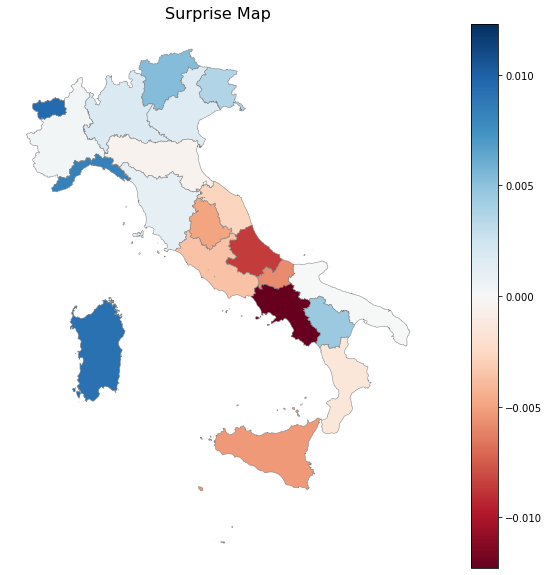

In [16]:
map_reg = gpd.read_file(os.path.join('..', 'assets', 'maps', 'Reg01012019_g', 'Reg01012019_g_WGS84.shp'))
map_reg['DEN_REG'] = map_reg['DEN_REG'].replace({'Friuli Venezia Giulia': 'Friuli-Venezia Giulia', 'Trentino-Alto Adige': 'Trentino Alto Adige / Südtirol', "Valle d'Aosta": "Valle d'Aosta / Vallée d'Aoste"})
# Merge the map with the pandas df
merged = pd.merge(map_reg, surprise_df, left_on='DEN_REG', right_on='Territory', how='left')

YEAR = '2018'
fig, ax = plt.subplots(1, figsize=(15, 10))
ax.axis('off')
ax.set_title('Surprise Map', fontsize=16)
cmap = plt.get_cmap('RdBu')
max_abs_value = max(np.abs(min(merged[YEAR])), np.abs(max(merged[YEAR])))
merged.plot(column=YEAR, vmin = -max_abs_value, vmax = max_abs_value, cmap=cmap, linewidth=0.5, ax=ax, edgecolor='0.5', legend=True)